In [14]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pathlib

In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
path = pathlib.Path.cwd()
path/'models/faceboxes.py'

WindowsPath('D:/Python/2018-12-20 Pytorch Motion Control/models/faceboxes.py')

### 1.0 Load and Evaluate Faceboxes Model

In [38]:
# Open image and convert to tensor
image = cv2.imread('data/lfw_2018.JPG', cv2.IMREAD_COLOR)

# Convert OpenCV BGR to matplotlib RGB
RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(RGB_im)

### FaceBoxes.Pytorch `test.py` imports 
* Removed nms references to evaluate on CPU

In [41]:
import os
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from data import cfg
from layers.functions.prior_box import PriorBox
import cv2
from models.faceboxes import FaceBoxes
from utils.box_utils import decode
from utils.timer import Timer

from utils.custom import nms_cpu, check_keys, load_model, remove_prefix

In [42]:

# ========================================================== #
#                  Load Model and Weights                    #
# ========================================================== #

pretrained_path = 'weights/FaceBoxes.pth'
args_cuda = False

# net and model
net = FaceBoxes(phase='test', size=None, num_classes=2)    # initialize detector
net = load_model(net, pretrained_path)
net.eval()
print('Finished loading model')
print(net)
if args_cuda:
    net = net.cuda()
    cudnn.benchmark = True
else:
    net = net.cpu()

Loading pretrained model from weights/FaceBoxes.pth
remove prefix 'module.'
Missing keys:27
Unused checkpoint keys:0
Used keys:147
Finished loading model
FaceBoxes(
  (conv1): CRelu(
    (conv): Conv2d(3, 24, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): CRelu(
    (conv): Conv2d(48, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception1): Inception(
    (branch1x1): BasicConv2d(
      (conv): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch1x1_2): BasicConv2d(
      (conv): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

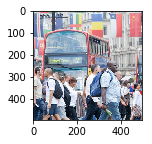

In [69]:
# ========================================================== #
# Image processing                                           #
# ========================================================== #

image_path = path/'data/lfw_224x224.jpg'
#image_path = path/'data/pedestrians_224.jpg'
image_path = path/'data/t1.jpg'
img_name = 'pedestrians'
resize = 1
_t = {'forward_pass': Timer(), 'nms': Timer()}

# ---------------- Image transformations -------------------
image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
img = np.float32(image)
RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# ----------------------------------------------------------

# Resizing
if resize != 1:
    img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
im_height, im_width, _ = img.shape
scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
img -= (104, 117, 123)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).unsqueeze(0)
if args_cuda:
    img = img.cuda()
    scale = scale.cuda()

plt.rcParams['figure.figsize'] = (2, 2)
plt.imshow(RGB_im)

In [70]:
# ========================================================== #
# Forward pass evaluation                                    #
# ========================================================== #

_t['forward_pass'].tic()
out = net(img)  # forward pass
_t['forward_pass'].toc()
_t['nms'].tic()
priorbox = PriorBox(cfg, out[2], (im_height, im_width), phase='test')
priors = priorbox.forward()
if args_cuda:
    priors = priors.cuda()
loc, conf, _ = out
prior_data = priors.data
boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
boxes = boxes * scale / resize
boxes = boxes.cpu().numpy()
scores = conf.data.cpu().numpy()[:, 1]


In [71]:
# Faceboxes model output tensors
for i in range(len(out)):
    print(out[i].shape)
print(len(scores), 'faceboxes detected')

torch.Size([1, 5456, 4])
torch.Size([5456, 2])
torch.Size([3, 2])
5456 faceboxes detected


In [72]:
scores

array([0.01452467, 0.01383184, 0.01509985, ..., 0.002097  , 0.00107548,
       0.00150646], dtype=float32)

In [73]:
# ========================================================== #
confidence_threshold = 0.05
top_k = 400
# ========================================================== #

# ignore low scores
inds = np.where(scores > confidence_threshold)[0]
boxes = boxes[inds]
scores = scores[inds]

# keep top-K scores before NMS
order = scores.argsort()[::-1][:top_k]
boxes = boxes[order]
scores = scores[order]

In [74]:
# Number of output predictions after thresholding
print('boxes after threshold:', len(scores))
print('forward pass: {:.4f} s'.format(_t['forward_pass'].average_time))

boxes after threshold: 167
forward pass: 0.0509 s


In [75]:
# ================= Note: NMS implemented ===================== #

nms_threshold = 0.3
keep_top_k = 10

# do NMS
dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
print(dets.shape)
keep = nms_cpu(dets, nms_threshold)
dets = dets[keep, :]

# Trim results above top-K
dets = dets[:keep_top_k]
_t['nms'].toc()

print('Applying Non-Max Supression \nFace boxes:', len(dets))
print('Forward pass and nms: {:.4f} s'.format(_t['nms'].average_time))

(167, 5)
Applying Non-Max Supression 
Face boxes: 10
Forward pass and nms: 0.9467 s


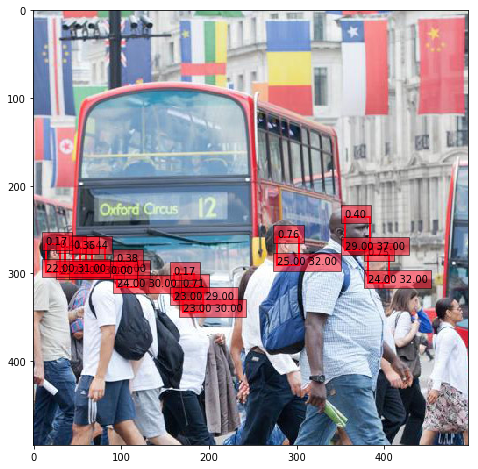

In [76]:
# ================== Plot the boxes ================== #

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
colors = plt.cm.hsv(np.linspace(0, 1, 2)).tolist()
plt.imshow(RGB_im)
currentAxis = plt.gca()

if len(dets.shape) == 1:  # edge case where nms has a single return
    dets = [dets]
    
# loop and draw boxes
for det in dets:
    xmin = int(round(det[0]))
    ymin = int(round(det[1]))
    xmax = int(round(det[2]))
    ymax = int(round(det[3]))
    score = det[4]
    display_txt = '%.2f' % (score)
    display_wh = '%.2f %.2f' % (xmax-xmin+1, ymax-ymin+1)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[1]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha': 0.5})
    currentAxis.text(xmin, ymax, display_wh, bbox={'facecolor': color, 'alpha': 0.5})
